<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/GNN%20model%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset prepare

In [ ]:
!pip install --quiet --upgrade gensim
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 616.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [219]:
# загружаем полный датасет
#raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=25000)
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ArrayArrowDataECGgraph.csv', nrows=25000, sep=';')
raw_table_data.head(5)

<ipython-input-219-29dd8e705a9f>:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ArrayArrowDataECGgraph.csv', nrows=25000, sep=';')


,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,13312271,30,40001422,6448421,0,12:31 PM,05.02.2011,Sinus rhythm,Left bundle branch block,NaN,...,60 Hz notch Baseline filter,923,40,144,180,322,614,71,-13,117
1,19289869,20,40001735,6108919,0,2:29 AM,13.06.2011,Sinus rhythm with occasional PACs,Left axis deviation,Left bundle branch block,...,60 Hz notch Baseline filter,800,40,110,184,316,612,63,-34,140
2,11372768,20,40001980,6632385,0,2:01 PM,01.07.2011,Accelerated junctional rhythm,Left bundle branch block,NaN,...,<not specified>,759,460,29999,499,633,930,32767,-32,100
3,14729395,30,40003136,6672155,0,8:52 PM,09.07.2011,Sinus rhythm,Possible anterior infarct - age undetermined,Inferior/lateral ST-T changes may be due to my...,...,60 Hz notch Baseline filter,612,40,182,212,314,580,70,-4,132
4,11933271,40,40003371,6037973,0,2:34 PM,08.04.2013,Sinus rhythm,Possible left atrial abnormality,Tall T waves - consider acute ischemia or hype...,...,60 Hz notch Baseline filter,612,40,128,172,250,506,58,-27,53


In [220]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]



# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.lower().split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,13312271,30,40001422,6448421,12:31 PM,05.02.2011,0.022471,923,40,144,180,322,614,71,-13,117,0
1,19289869,20,40001735,6108919,2:29 AM,13.06.2011,0.019913,800,40,110,184,316,612,63,-34,140,0
3,14729395,30,40003136,6672155,8:52 PM,09.07.2011,0.003449,612,40,182,212,314,580,70,-4,132,0
4,11933271,40,40003371,6037973,2:34 PM,08.04.2013,0.009672,612,40,128,172,250,506,58,-27,53,0
8,15726063,20,40006307,6920139,8:01 AM,25.11.2009,-0.036974,1034,40,154,216,308,646,50,59,69,1


In [221]:
# make new dataset from old columns
table_data = full_df_filtered[['subject_id','study_id','eeg_date','report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data['eeg_date'] = pd.to_datetime(table_data['eeg_date'],dayfirst=True)
table_data = table_data.sort_values(by=['subject_id', 'eeg_date'])

#table_data = table_data.head(1000)

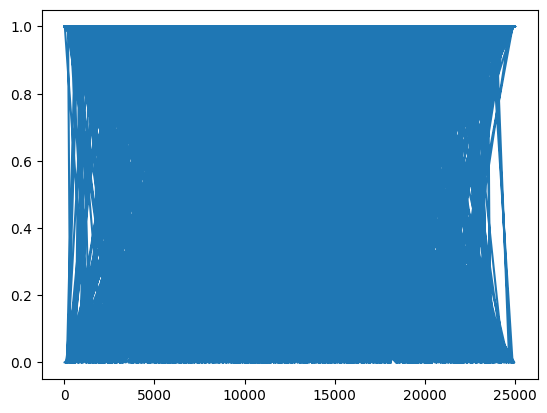

In [222]:
duplicate_index = table_data['subject_id'].duplicated()
plt.plot(duplicate_index)

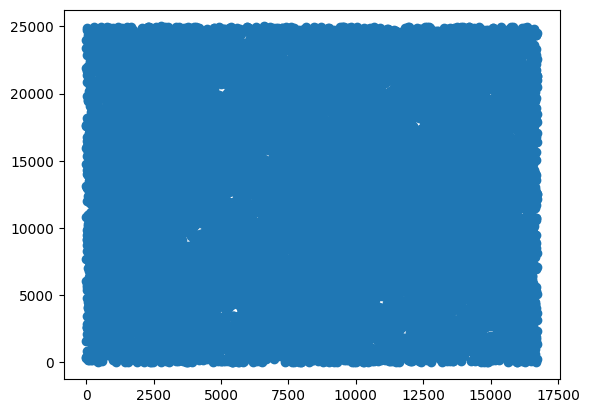

In [223]:

duplicate_index = duplicate_index[duplicate_index[:]==True].index
plt.scatter(range(0,len(duplicate_index)), duplicate_index)

In [224]:
table_data.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,10002430,46776688,2011-01-08,-0.024331,800,148,208,306,572,66,54,70,1
6030,10002430,42430320,2011-03-10,0.018083,714,140,230,350,636,47,63,33,0
21880,10002430,48702630,2012-03-09,0.026485,1034,164,198,316,674,-52,64,36,0
1601,10002430,40634706,2013-03-29,-0.034963,594,142,180,256,520,39,23,21,1
13125,10002430,45250519,2013-11-26,-0.024139,1071,176,268,410,706,33,-65,76,0


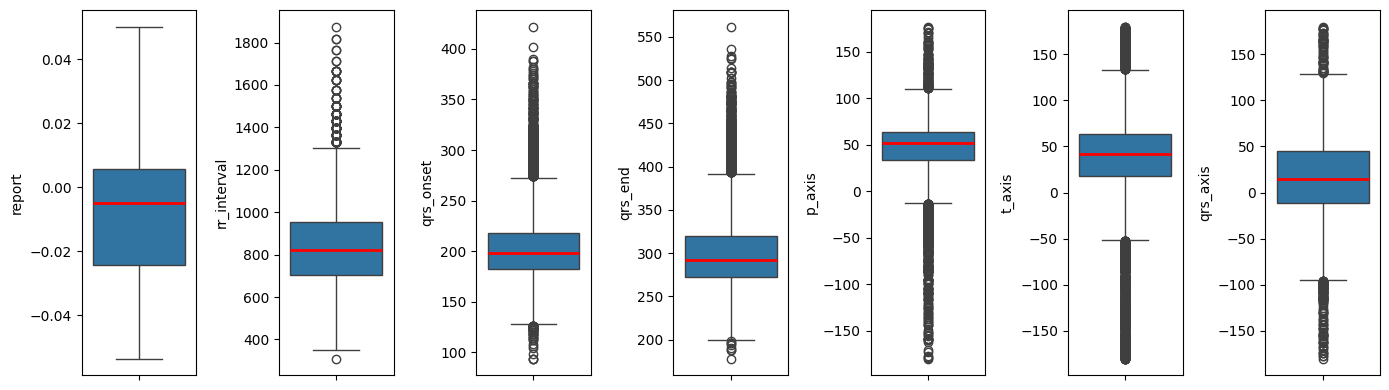

In [225]:
view_table_data = table_data[['report','rr_interval','qrs_onset','qrs_end','p_axis','t_axis','qrs_axis']]

n = view_table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=False)
for i in range(n):
    plt.sca(ax[i])
    col = view_table_data.columns[i]
    sns.boxplot(y = view_table_data.iloc[:,i],data=view_table_data, medianprops={"color": "r", "linewidth": 2})
    fig.tight_layout()

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

# Graph Network Visualization

In [226]:
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

import networkx as nx

In [227]:
encoder = LabelEncoder()
columns_to_encode = list(set(table_data.columns) - {"subject_id","study_id"})
ecg_table = table_data
#ecg_table["eeg_date"] = encoder.fit_transform(ecg_table["eeg_date"])
for col in columns_to_encode:
    ecg_table[col] = encoder.fit_transform(ecg_table[col])

ecg_table.describe()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
count,1.770300e+04,1.770300e+04,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000
mean,1.499018e+07,4.501793e+07,1359.223239,2468.845563,75.490934,49.235610,50.379540,55.585663,100.403604,180.116477,164.162571,219.799638,0.279388
std,2.830020e+06,2.877138e+06,700.801934,2156.921139,17.444695,9.230378,16.143473,20.827120,30.930900,28.408823,40.845723,49.699325,0.448711
min,1.000243e+07,4.000142e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.253510e+07,4.253763e+07,776.500000,325.000000,66.000000,44.000000,40.000000,42.000000,80.000000,167.000000,138.000000,197.000000,0.000000
50%,1.512751e+07,4.501460e+07,1357.000000,1978.000000,78.000000,50.000000,48.000000,52.000000,99.000000,186.000000,164.000000,221.000000,0.000000
75%,1.740923e+07,4.751539e+07,1953.000000,4353.500000,88.000000,55.000000,58.000000,66.000000,119.000000,198.000000,194.000000,243.000000,1.000000
max,1.998526e+07,4.995937e+07,2803.000000,6723.000000,119.000000,85.000000,143.000000,163.000000,233.000000,294.000000,313.000000,359.000000,1.000000


In [228]:
class_values = sorted(ecg_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values


subject_idx = {name: idx for idx, name in enumerate(sorted(ecg_table["subject_id"].unique()))}
ecg_table["subject_id"] = ecg_table["subject_id"].apply(lambda name: subject_idx[name])

#ecg_table.head()

study_idx = {name: idx for idx, name in enumerate(sorted(ecg_table["study_id"].unique()))}
ecg_table["study_id"] = ecg_table["study_id"].apply(lambda name: study_idx[name])

#papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [229]:
len(ecg_table['Healthy_Status'])

17703

In [230]:
ecg_table['Healthy_Status'].sum()

4946

In [231]:
ecg_table

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,325,76,49,53,59,86,200,203,249,1
6030,0,4228,519,6049,67,45,64,81,118,181,212,212,0
21880,0,15434,884,6465,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,62,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,330,95,63,83,111,153,167,84,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17907,976,12626,2082,5209,88,26,24,32,64,203,231,222,0
21044,976,14850,2084,299,68,51,78,73,112,214,215,254,0
3689,976,2584,2463,5698,67,46,53,46,77,171,184,215,0
277,976,202,2466,2913,89,58,66,75,124,180,68,269,0


## edge end nodes vizualisation

In [232]:
# Находим дубликаты по 'subject_id'
duplicated_rows = table_data[table_data.duplicated(subset=['subject_id'], keep=False)]

# Сортируем для удобства (опционально)
duplicated_rows = duplicated_rows.sort_values(by='subject_id')
print(len(duplicated_rows))
duplicated_rows.head()

17703


,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,325,76,49,53,59,86,200,203,249,1
15940,0,11250,2668,1191,102,42,101,126,221,145,80,200,0
14763,0,10444,2349,1487,68,33,44,60,67,242,129,311,0
7709,0,5429,2140,1552,76,51,55,58,116,171,222,240,0
17692,0,12484,1842,687,78,48,50,46,93,211,234,258,1


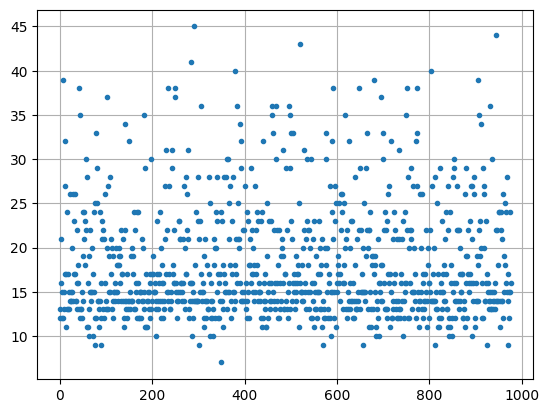

In [233]:
subject_freq = duplicated_rows.groupby('subject_id')['study_id'].nunique()
plt.plot(subject_freq,'.')
plt.grid()

In [234]:
subject_freq

,study_id
subject_id,
0,12
1,13
2,21
3,16
4,12
...,...
972,12
973,15
974,15


In [235]:
max(pd.unique(duplicated_rows['subject_id']))

976

In [236]:
one_patient_df = duplicated_rows[duplicated_rows["subject_id"] == 1]
one_patient_df = one_patient_df.sort_values('eeg_date')
one_patient_df

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
11898,1,8394,168,3648,69,44,57,65,102,180,239,103,0
10821,1,7625,773,3142,87,51,50,54,99,210,216,143,0
390,1,279,1348,4658,68,38,35,72,98,191,196,169,0
17631,1,12443,1604,2499,85,47,32,35,84,165,145,296,0
21385,1,15080,1757,2748,84,63,47,50,117,201,206,232,0
5800,1,4058,1815,6624,46,48,38,40,52,213,226,231,0
1680,1,1178,1840,32,103,24,33,32,97,193,187,215,1
16773,1,11834,1944,2342,57,58,57,62,90,165,174,192,0
22872,1,16165,2037,3797,83,60,48,46,113,177,154,222,0
18166,1,12818,2159,2495,52,32,33,30,49,169,152,180,0


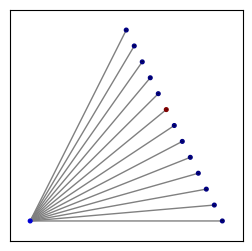

In [237]:
graph_model = pd.DataFrame(
    {
        "source": one_patient_df['subject_id'],
        "target": one_patient_df['report'],
        "edge_key": one_patient_df['eeg_date'],
        "weight": one_patient_df['report'],
        "status": one_patient_df['Healthy_Status'],
    }
)

color_map = []

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

for node in G.nodes():
    # Example: use the average status of all connected edges
    edge_statuses = [data['status'] for _, _, data in G.edges(node, data=True)]
    avg_status = sum(edge_statuses)/len(edge_statuses) if edge_statuses else 0
    color_map.append(avg_status)

plt.figure(figsize=(3, 3))
nx.draw_networkx(
    G,
    pos=nx.planar_layout(G),
    node_size=7,
    font_size=0,
    edge_color='grey',
    node_color=color_map,
    cmap=plt.cm.jet
)
plt.show()

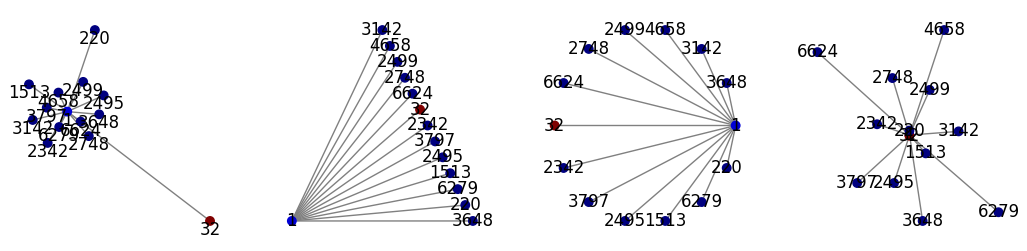

In [238]:
plt.figure(figsize=(13,3))
# plt.subplot() will create "sub-plots" in one canvas
# Now we are telling matplotlib to give us a 2x2 subplot canvas
plt.subplot(141)  # first subplot
nx.draw_spring(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet, verticalalignment='top', node_size=37, edge_color='grey')
plt.subplot(142) # second subplot
nx.draw_planar(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')
plt.subplot(143) # third subplot
nx.draw_circular(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')
plt.subplot(144) # last subplot
nx.draw_kamada_kawai(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')

In [239]:
#duplicated_rows=duplicated_rows.head(len(duplicated_rows)//2)
#duplicated_rows = duplicated_rows.sample(500)
graph_model = pd.DataFrame(
    {
        "source": duplicated_rows['subject_id'],
        "target": duplicated_rows['study_id'],
        "edge_key": duplicated_rows['eeg_date'],
        "weight": duplicated_rows['report'],
        "status": duplicated_rows['Healthy_Status'],
    }
)
print(len(graph_model))

17703


In [241]:
G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

color_map = graph_model['status'].to_numpy()
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, pos=nx.spring_layout(G),
                 node_size=7, font_size = 0,edge_color ='grey',
                 #node_color=color_map,
                 )

KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, alpha=0.1, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.1, edge_color="b", style="solid"
)


ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
#plt.tight_layout()
plt.show()


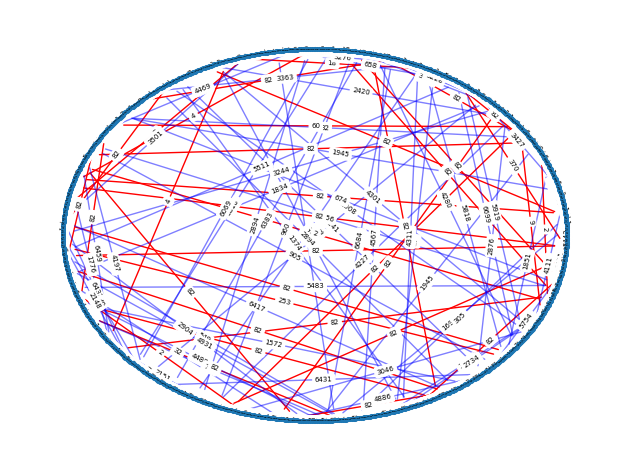

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="solid"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


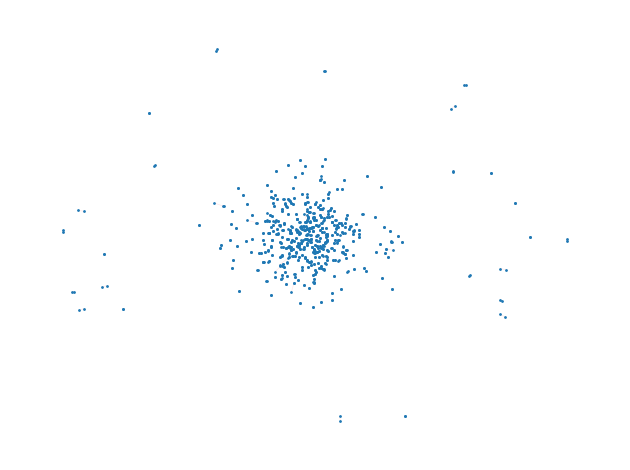

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.spring_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=0.5, alpha=0.1, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=0.5, alpha=0.1, edge_color="b", style="dashed")

# node labels
#nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# If you want to color nodes based on some aggregation of their connected edges' status
color_map = []
for node in G.nodes():
    # Example: use the average status of all connected edges
    edge_statuses = [data['status'] for _, _, data in G.edges(node, data=True)]
    avg_status = sum(edge_statuses)/len(edge_statuses) if edge_statuses else 0
    color_map.append(avg_status)

plt.figure(figsize=(8, 8))
nx.draw_networkx(
    G,
    pos=nx.kamada_kawai_layout(G),
    node_size=17,
    font_size=0,
    edge_color='grey',
    node_color=color_map,
    cmap=plt.cm.viridis
)
plt.show()

KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

#Graph Neural Network vs MLP

In [242]:
import tensorflow as tf

In [243]:
ecg_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,325,76,49,53,59,86,200,203,249,1
6030,0,4228,519,6049,67,45,64,81,118,181,212,212,0
21880,0,15434,884,6465,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,62,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,330,95,63,83,111,153,167,84,255,0


In [244]:
#class_values = sorted(ecg_table["Healthy_Status"].unique())
class_values = sorted(graph_model["status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

[0, 1]

In [255]:
train_data, test_data = [], []

#for _, group_data in ecg_table.groupby("subject_id"):
for _, group_data in graph_model.groupby("status"):
#for _, group_data in graph_model.groupby("source"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14187, 5)
Test data shape: (3516, 5)


## Vanila MLP NN

In [274]:
train_data, test_data = [], []

for _, group_data in ecg_table.groupby("subject_id"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14131, 13)
Test data shape: (3572, 13)


In [265]:
feature_names = list(set(ecg_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Healthy_Status"]
y_test = test_data["Healthy_Status"]

In [256]:
#feature_names = list(set(ecg_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
feature_names = list(set(graph_model.columns) - {"status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
#y_train = train_data["Healthy_Status"]
#y_test = test_data["Healthy_Status"]
y_train = train_data["status"]
y_test = test_data["status"]

In [266]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 256

In [267]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [268]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │      1,576 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 2)         │         66 │ skip_connection5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,114 (43.41 KB)

 Trainable params: 10,518 (41.09 KB)

 Non-trainable params: 596 (2.33 KB)

In [269]:

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [270]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")

    plt.grid()
    plt.show()

In [271]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - acc: 0.6386 - loss: 1.3382 - val_acc: 0.7333 - val_loss: 3.4820
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7571 - loss: 0.4565 - val_acc: 0.7333 - val_loss: 0.7126
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.7868 - loss: 0.4174 - val_acc: 0.7916 - val_loss: 0.3195
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.8012 - loss: 0.3844 - val_acc: 0.8274 - val_loss: 0.2732
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8041 - loss: 0.3797 - val_acc: 0.9233 - val_loss: 0.2404
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7940 - loss: 0.3798 - val_acc: 0.9149 - val_loss: 0.2343
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8044 - loss: 0.3797 - val_acc: 0.9323 - val_loss: 0.2182
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8152 - loss: 0.3584 - val_acc: 0.9163 - val_loss: 0.2181
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.815

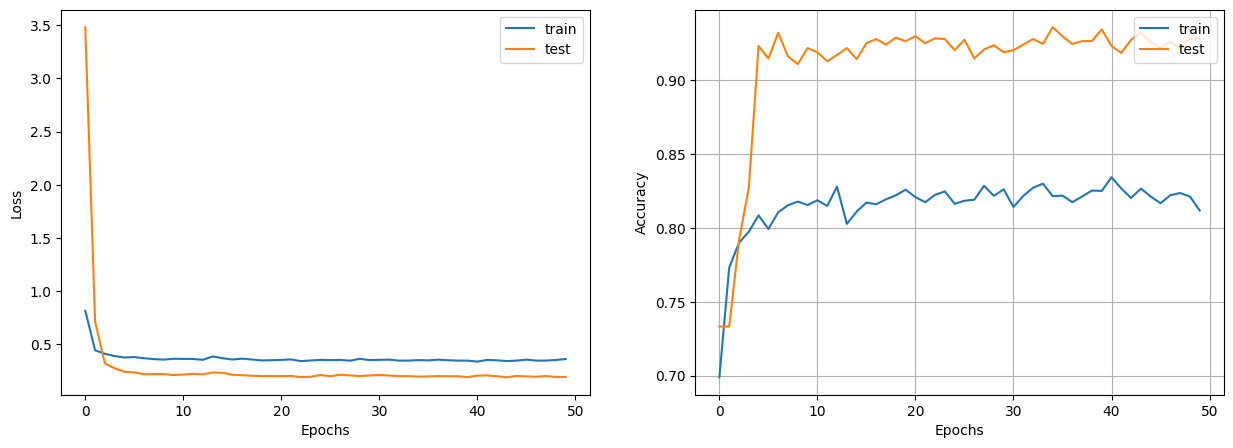

In [272]:
display_learning_curves(history)

In [273]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 94.06%


In [275]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [276]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Instance 1:
- 0: 100.0%
- 1: 0.0%
Instance 2:
- 0: 100.0%
- 1: 0.0%


## graph neural network

In [201]:
ecg_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,57,76,49,53,59,86,200,203,249,1
6030,0,4228,519,5828,67,45,64,81,118,181,212,212,0
21880,0,15434,884,5266,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,31,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,660,95,63,83,111,153,167,84,255,0


In [202]:
class_values = sorted(ecg_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

[0, 1]

In [203]:
train_data, test_data = [], []

for _, group_data in ecg_table.groupby("subject_id"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14161, 13)
Test data shape: (3542, 13)


In [204]:
feature_names = list(set(ecg_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Healthy_Status"]
y_test = test_data["Healthy_Status"]

In [205]:
np.shape(x_train)

(14161, 10)

In [206]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = ecg_table[["subject_id", "study_id"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    ecg_table.sort_values("subject_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 17703)
Nodes shape: (17703, 10)


In [207]:
node_features[1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([2668.,  221.,   42.,  126.,  200.,   80.,  102.,  101., 2551.,
        145.], dtype=float32)>

In [208]:

def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [209]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="mean",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [210]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

#print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [215]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 256

In [216]:
#x_train = train_data.report.to_numpy()
x_train = train_data.subject_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - acc: 0.6589 - loss: 1.4760 - val_acc: 0.7252 - val_loss: 0.5885
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - acc: 0.7219 - loss: 0.5915 - val_acc: 0.7252 - val_loss: 0.5882
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - acc: 0.7191 - loss: 0.5938 - val_acc: 0.7252 - val_loss: 0.5881
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - acc: 0.7182 - loss: 0.5951 - val_acc: 0.7252 - val_loss: 0.5883
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - acc: 0.7236 - loss: 0.5960 - val_acc: 0.7252 - val_loss: 0.5880
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - acc: 0.7142 - loss: 0.6005 - val_acc: 0.7252 - val_loss: 0.5892
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - acc: 0.7246 - loss: 0.5896 - val_acc: 0.7252 - val_loss: 0.5884
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - acc: 0.7226 - loss: 0.5906 - val_acc: 0.7252 - val_loss: 0.5885
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10

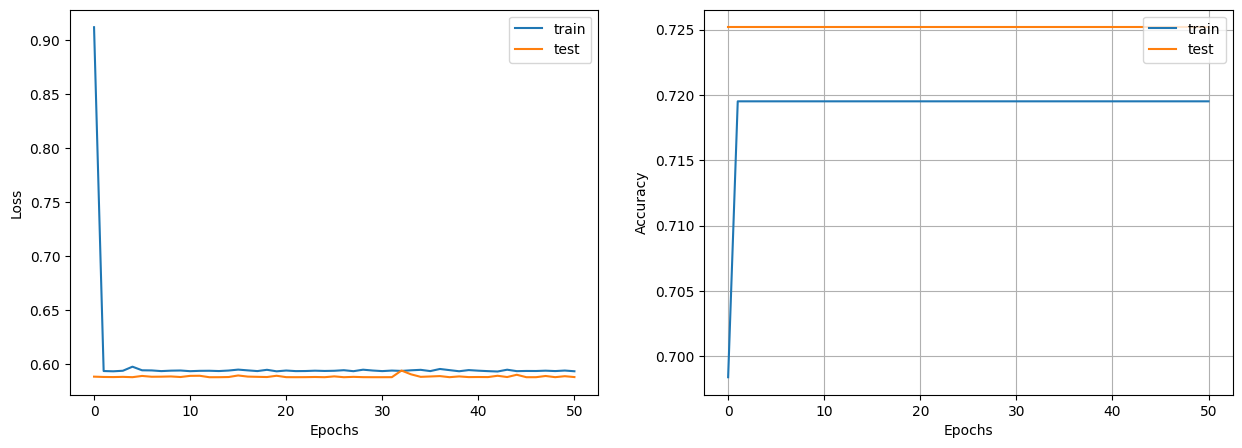

In [217]:
display_learning_curves(history)

In [214]:
x_test = test_data.report.to_numpy()
#x_test = test_data.source.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.16%


In [ ]:
#new_instances = generate_random_instances(num_classes)
token_probability = x_train.mean(axis=0)
instances = []
for _ in range(5):
        probabilities = np.random.uniform(size = num_features)
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)
new_instances = instances

In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]


## Create a node features array of shape [num_nodes, num_features].
##node_features = tf.cast(
##    ecg_table.sort_values("subject_id")[feature_names].to_numpy(),
##    dtype=tf.dtypes.float32)

new_node_features = np.concatenate([node_features, new_instances])

# Second we add the M edges (it's a kind of next patient visits) from each new node to a set
# of existing nodes in a particular subject

new_node_indices = [i + num_nodes for i in range(3)]

new_patient_visits = []
for subject_idx, group in ecg_table.groupby("Healthy_Status"):
    subject_patient = list(group.subject_id)
    # Select random x nodes specific patient.
    selected_node_indices1 = np.random.choice(subject_patient, 5)
    # Select random y nodes from any subject as a patient (where y < x).
    selected_node_indices2 = np.random.choice(list(ecg_table.subject_id), 2)
    # Merge the selected node indices.
    selected_node_indices = np.concatenate(
        [selected_node_indices1, selected_node_indices2], axis=0
    )
    # Create edges between a patient visits idx and the selected subject.
    patient_indx = new_node_indices[subject_idx]
    for old_patient_visit_idx in selected_node_indices:
        new_patient_visits.append([patient_indx, old_patient_visit_idx])


new_patient_visits = np.array(new_patient_visits).T
new_edges = np.concatenate([edges, new_patient_visits], axis=1)

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (17703, 10)
Original edges shape: (2, 17703)
New node_features shape: (17708, 10)
New edges shape: (2, 17717)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Instance 1:
- 0: 13.19%
- 1: 86.81%
Instance 2:
- 0: 83.59%
- 1: 16.41%
Instance 3:
- 0: 99.41%
- 1: 0.59%


In [ ]:
view_ecg_table = ecg_table.sample(n=100)

graph_model = pd.DataFrame(
    {
        "source": view_ecg_table['subject_id'],
        "target": view_ecg_table['report'],
        "edge_key": view_ecg_table['eeg_date'],
        "weight": view_ecg_table['report'],
        "status": view_ecg_table['Healthy_Status'],
    }
)

graph_model.head()

,source,target,edge_key,weight,status
11971,730,876,1877,876,0
5309,654,82,915,82,1
24665,501,21,2251,21,1
17665,89,5286,2003,5286,0
1847,376,2963,940,2963,0


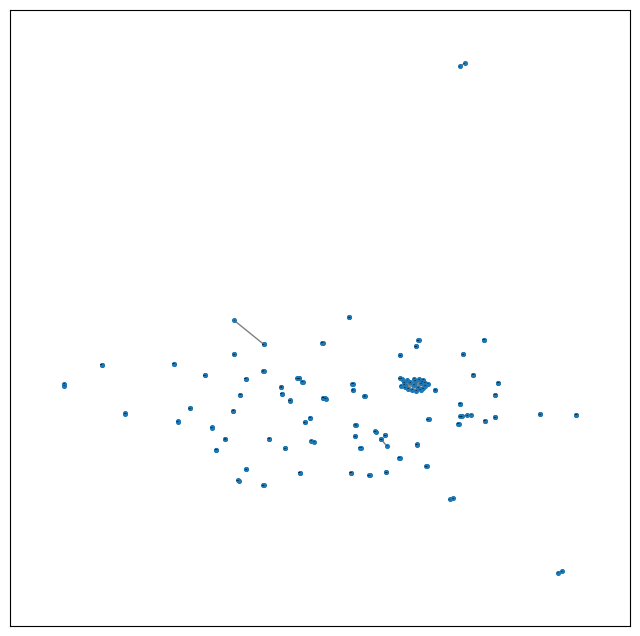

In [ ]:

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

plt.figure(figsize=(8, 8))

nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=7, font_size = 1,edge_color ='grey')



# Torch framework graph GCN model

In [ ]:
!pip install -q torch_geometric

In [ ]:
import torch
torchversion = torch.__version__

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.utils import to_networkx

import networkx as nx

In [ ]:
import random

In [ ]:
class CustomGraphDataset(Dataset):
    def __init__(self, num_graphs=10, num_nodes_per_graph=20,
                 num_features=15, num_classes=2, train_ratio=0.8,
                 seed=42):
        """
        Optimized in-memory graph dataset without file I/O.

        Args:
            num_graphs: Number of graphs to generate
            num_nodes_per_graph: Nodes per graph
            num_features: Features per node
            num_classes: Number of classes
            train_ratio: Ratio of training nodes (0-1)
            seed: Random seed for reproducibility
        """
        super().__init__()
        self._num_graphs = num_graphs
        self._num_nodes = num_nodes_per_graph
        self._num_features = num_features
        self._num_classes = num_classes
        self._train_ratio = train_ratio  # Store as protected attribute
        self._seed = seed

        # Set random seeds
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Generate all graphs upfront
        self.graphs = [self._generate_graph(i) for i in range(num_graphs)]

    @property
    def train_ratio(self):
        """Public accessor for train_ratio"""
        return self._train_ratio

    def _generate_graph(self, graph_idx):
        """Generate a single graph with all required attributes."""
        # Node features
        x = torch.rand(self.num_nodes, self.num_features)

        # Edge connections (small-world)
        edge_index = []
        for j in range(self.num_nodes):
            for k in range(random.randint(0,5)):
                edge_index.append([j, (j + k) % self.num_nodes])
                edge_index.append([(j + k) % self.num_nodes, j])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        # Class labels (balanced)
        y = torch.tensor([i % self.num_classes for i in range(self.num_nodes)],
                        dtype=torch.long)
        y = y[torch.randperm(self.num_nodes)]

        # Train/test masks
        indices = torch.arange(self.num_nodes)
        train_idx, test_idx = train_test_split(
            indices,
            test_size=1-self.train_ratio,  # Now properly accessible
            random_state=self._seed + graph_idx,
            stratify=y.numpy()
        )
        #val_idx=test_idx

        train_idx, val_idx = train_test_split(
            train_idx,
            test_size=1-self.train_ratio,  # Now properly accessible
            random_state=self._seed + graph_idx,
         #   stratify=y.numpy()
        )
        #val_idx=test_idx


        train_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        train_mask[train_idx] = True
        test_mask[test_idx] = True
        val_mask[val_idx] = True


        # Verify we have actual training samples
        assert train_mask.sum() > 0, "No training nodes!"
        assert test_mask.sum() > 0, "No test nodes!"

        return Data(
            x=x,
            edge_index=edge_index,
            y=y,
            train_mask=train_mask,
            test_mask=test_mask,
            val_mask=val_mask,
            num_classes=self.num_classes
        )

    @property
    def num_graphs(self):
        return self._num_graphs

    @property
    def num_nodes(self):
        return self._num_nodes

    @property
    def num_features(self):
        return self._num_features

    @property
    def num_classes(self):
        return self._num_classes

    def len(self):
        return self.num_graphs

    def get(self, idx):
        return self.graphs[idx]

    def __repr__(self):
        return (f'{self.__class__.__name__}({len(self)}, '
                f'nodes={self.num_nodes}, '
                f'features={self.num_features}, '
                f'classes={self.num_classes}, '
                f'train_ratio={self.train_ratio})')

In [ ]:
dataset = CustomGraphDataset(
        num_graphs=10,
        num_nodes_per_graph=45,
        num_features=13,
        num_classes=2,
        train_ratio=0.7
    )

print(f"Created dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")

Created dataset: CustomGraphDataset(10, nodes=45, features=13, classes=2, train_ratio=0.7)
Number of graphs: 10
Number of classes: 2


In [ ]:
data=dataset[0]

In [ ]:
data.y

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0])

In [ ]:
    # Examine first graph
sample = dataset[0]
print("\nSample graph info:")
print(f"Nodes: {sample.num_nodes}")
print(f"Edges: {sample.num_edges}")
print(f"Features: {sample.num_features}")
print(f"Classes present: {torch.unique(sample.y)}")


Sample graph info:
Nodes: 45
Edges: 208
Features: 13
Classes present: tensor([0, 1])


In [ ]:

print("\nClass distribution:")
for cls in range(dataset.num_classes):
  print(f"Class {cls}: {torch.sum(sample.y == cls).item()} nodes")

print("\nTrain/test split:")
print(f"Training nodes: {sample.train_mask.sum().item()}")
print(f"Test nodes: {sample.test_mask.sum().item()}")

    # Verify class balance in splits
print("\nClass distribution in training set:")
for cls in range(dataset.num_classes):
  train_nodes = torch.sum((sample.y == cls) & sample.train_mask).item()
  print(f"Class {cls}: {train_nodes} nodes")

print("\nClass distribution in test set:")
for cls in range(dataset.num_classes):
  test_nodes = torch.sum((sample.y == cls) & sample.test_mask).item()
  print(f"Class {cls}: {test_nodes} nodes")



Class distribution:
Class 0: 23 nodes
Class 1: 22 nodes

Train/test split:
Training nodes: 21
Test nodes: 14

Class distribution in training set:
Class 0: 10 nodes
Class 1: 11 nodes

Class distribution in test set:
Class 0: 7 nodes
Class 1: 7 nodes


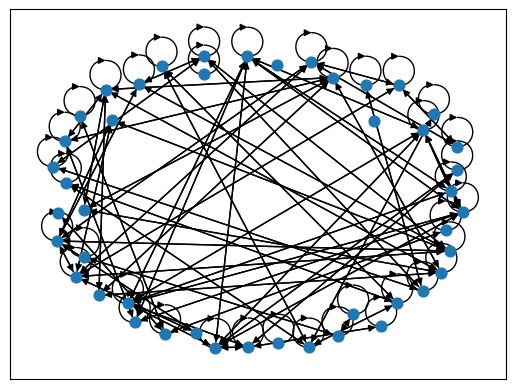

In [ ]:
networkX_graph = to_networkx(sample, node_attrs=["x"])


# Draw the graph
pos = nx.spring_layout(networkX_graph, k=13)
nx.draw_networkx(
    networkX_graph,
    pos=pos,
    with_labels=False,
    node_size=60,
)
plt.show()


In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 350

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 5, dataset.num_classes)
#gcn = GCN(1, 16, 1)

print(gcn)


GCN(
  (gcn1): GCNConv(13, 5)
  (gcn2): GCNConv(5, 2)
)
CPU times: user 4.05 ms, sys: 0 ns, total: 4.05 ms
Wall time: 5.38 ms


In [ ]:
# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 0.709 | Train Acc:  57.14% | Val Loss: 0.65 | Val Acc: 50.00%
Epoch  10 | Train Loss: 0.712 | Train Acc:  47.62% | Val Loss: 0.69 | Val Acc: 40.00%
Epoch  20 | Train Loss: 0.729 | Train Acc:  47.62% | Val Loss: 0.71 | Val Acc: 40.00%
Epoch  30 | Train Loss: 0.664 | Train Acc:  52.38% | Val Loss: 0.70 | Val Acc: 40.00%
Epoch  40 | Train Loss: 0.659 | Train Acc:  71.43% | Val Loss: 0.69 | Val Acc: 50.00%
Epoch  50 | Train Loss: 0.678 | Train Acc:  57.14% | Val Loss: 0.68 | Val Acc: 60.00%
Epoch  60 | Train Loss: 0.710 | Train Acc:  33.33% | Val Loss: 0.70 | Val Acc: 40.00%
Epoch  70 | Train Loss: 0.635 | Train Acc:  61.90% | Val Loss: 0.71 | Val Acc: 30.00%
Epoch  80 | Train Loss: 0.707 | Train Acc:  52.38% | Val Loss: 0.71 | Val Acc: 50.00%
Epoch  90 | Train Loss: 0.662 | Train Acc:  76.19% | Val Loss: 0.65 | Val Acc: 70.00%
Epoch 100 | Train Loss: 0.654 | Train Acc:  76.19% | Val Loss: 0.67 | Val Acc: 40.00%
Epoch 110 | Train Loss: 0.752 | Train Acc:  57.14% | V

In [ ]:
from sklearn.manifold import TSNE

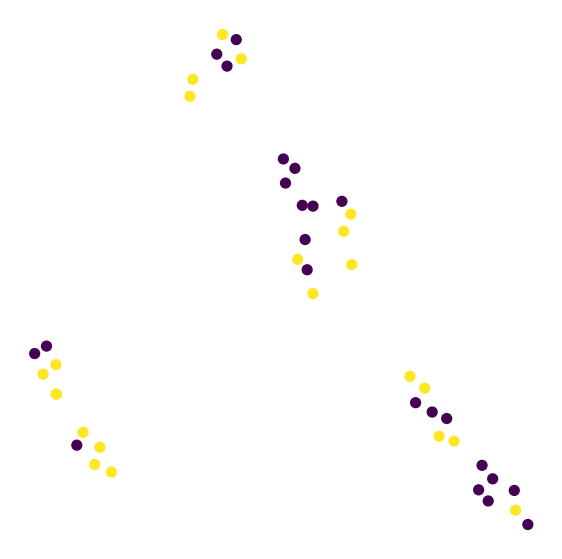

In [ ]:
# Get embeddings
h, _ = gcn(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, perplexity=5.0, learning_rate='auto', init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# Old ECG graph visualisation

In [ ]:
edge_index = torch.from_numpy(graph_model[["source", "target"]].to_numpy())
#node_features = torch.from_numpy(np.array(graph_model["weight"].tolist()))
node_features = torch.from_numpy(np.array(graph_model["weight"].to_numpy()))

#label = torch.from_numpy(np.array(graph_model["status"].tolist()))
label = torch.from_numpy(graph_model[["status"]].to_numpy())

edge_attr = torch.from_numpy(graph_model[["weight"]].to_numpy())

#data = Data(x=x, edge_index=edge_index.T)
data = Data(x=node_features,
            #edge_index=edge_index,
            edge_index=edge_index.t().contiguous(),
            edge_attr=edge_attr,
            y=label, #you can add more arguments as you like
                    )
data
#data.num_features

Data(x=[100], edge_index=[2, 100], edge_attr=[100, 1], y=[100, 1])

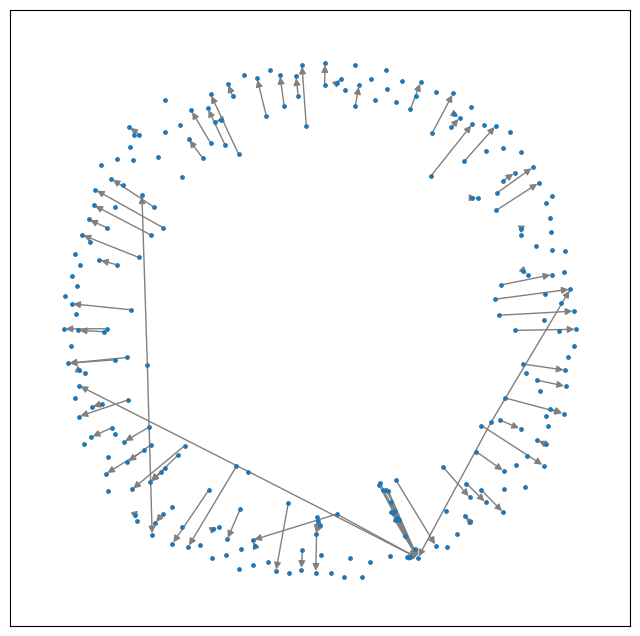

In [ ]:
graph = to_networkx(data, node_attrs=["x"], edge_attrs=["edge_attr"])
# Draw the graph

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(graph)#, k=2)
nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=False,
    edge_color='grey',
    node_size=6,
)
plt.show()

In [ ]:
G.edges(data=True)

MultiEdgeDataView([(699, 5357, {'weight': 5357, 'status': 0}), (910, 5799, {'weight': 5799, 'status': 0}), (128, 5499, {'weight': 5499, 'status': 0}), (436, 6320, {'weight': 6320, 'status': 0}), (883, 382, {'weight': 382, 'status': 0}), (928, 1441, {'weight': 1441, 'status': 0}), (849, 1821, {'weight': 1821, 'status': 1}), (1821, 953, {'weight': 1821, 'status': 1}), (1821, 313, {'weight': 1821, 'status': 1}), (1821, 597, {'weight': 1821, 'status': 1}), (1821, 825, {'weight': 1821, 'status': 1}), (1821, 279, {'weight': 1821, 'status': 1}), (1821, 580, {'weight': 1821, 'status': 1}), (1821, 609, {'weight': 1821, 'status': 1}), (1821, 945, {'weight': 1821, 'status': 1}), (1821, 164, {'weight': 1821, 'status': 1}), (1821, 761, {'weight': 1821, 'status': 1}), (1821, 611, {'weight': 1821, 'status': 1}), (1821, 384, {'weight': 1821, 'status': 1}), (1821, 475, {'weight': 1821, 'status': 1}), (1821, 36, {'weight': 1821, 'status': 1}), (1821, 764, {'weight': 1821, 'status': 1}), (1821, 631, {'we